In [26]:
import numpy as np
import scipy.linalg as lin
from scipy.linalg import cho_factor, cho_solve, inv

def ACE(M, t):
    """
    Performs the adaptive cosin/coherent estimator algorithm for target
    detection.

    Parameters:
        M: `numpy array`
            2d matrix of HSI data (N x p).

        t: `numpy array`
            A target endmember (p).

    Returns: `numpy array`
        Vector of detector output (N).

    References:
      X Jin, S Paswater, H Cline.  "A Comparative Study of Target Detection
      Algorithms for Hyperspectral Imagery."  SPIE Algorithms and Technologies
      for Multispectral, Hyperspectral, and Ultraspectral Imagery XV.  Vol
      7334.  2009.
    """
    N, p = M.shape
    # Remove mean from data
    u = M.mean(axis=0)
    print(u[0])
    print(u.shape)
    print(np.kron(np.ones((N, 1)), u).shape)
    M = M - np.kron(np.ones((N, 1)), u)
    print(M.dtype)
    print(M[0][0])
    t = t - u;
    print(t.dtype)
    print(t[0])

    R_hat = np.cov(M.T).astype(np.float32)
    print(R_hat[0][0].item())
    print(R_hat.dtype)
    G = lin.inv(R_hat.astype(np.float32))
    
    print(G)
    print(G[0][0])
    print(G.dtype)

    results = np.zeros(N, dtype=np.float32)
    print(results[0])
    ##% From Broadwater's paper
    ##%tmp = G*S*inv(S.'*G*S)*S.'*G;
    tmp = np.array(np.dot(t.T, np.dot(G, t)))
    print(tmp)
    dot_G_M = np.dot(G, M[0:,:].T)
    print(dot_G_M[0][0])
    num = np.square(np.dot(t, dot_G_M))
    print(num[0])
    for k in range(N):
        denom = np.dot(tmp, np.dot(M[k], dot_G_M[:,k]))
        results[k] = num[k] / denom
    print(results[0])
    return results
def ACE_sped_up(M, t):
    """
    Optimized Adaptive Coherent Estimator (ACE) using Cholesky decomposition.
    """
    N, p = M.shape
    # Remove mean
    u = M.mean(axis=0)
    M = M - u
    t = t - u

    # Estimate covariance and compute its inverse using Cholesky decomposition
    R_hat = np.cov(M, rowvar=False)
    L, lower = cho_factor(R_hat, lower=True)  # Cholesky decomposition
    Gt = cho_solve((L, lower), t)  # Solve G @ x = t
    GM = cho_solve((L, lower), M.T)  # Solve G @ X = M.T

    # Compute ACE score
    tmp = t @ Gt  # Scalar
    num = (t @ GM) ** 2  # Vectorized numerator
    denom = tmp * np.einsum('ij,ji->i', M, GM)  # Vectorized denominator

    return num / denom

def ACE_sped_up_2(M, t):
    # Ensure contiguous float32 arrays
    M = np.ascontiguousarray(M, dtype=np.float32)
    t = np.ascontiguousarray(t, dtype=np.float32)
    
    u = M.mean(axis=0)
    M_centered = M - u  # [N, p]
    t_centered = t - u  # [p]
    N, p = M_centered.shape
    
    # Efficient covariance computation
    R_hat = (M_centered.T @ M_centered) / (N - 1)
    
    # Cholesky decomposition and solves
    L, lower = cho_factor(R_hat, lower=True)
    Gt = cho_solve((L, lower), t_centered)
    GM = cho_solve((L, lower), M_centered.T)  # [p, N]
    
    # Vectorized score calculation
    tmp = t_centered @ Gt  # Scalar
    num = (t_centered @ GM) ** 2
    denom = tmp * (M_centered * GM.T).sum(axis=1)
    
    return num / denom

def ACE_sped_up_3(M, t):
    M = np.ascontiguousarray(M, dtype=np.float32)
    t = np.ascontiguousarray(t, dtype=np.float32)
    
    u = M.mean(axis=0)
    M_centered = M - u
    t_centered = t - u
    N, p = M_centered.shape
    
    # Manual covariance
    R_hat = (M_centered.T @ M_centered) / (N - 1)
    
    # NumPy Cholesky decomposition
    L = np.linalg.cholesky(R_hat)  # Lower triangular by default
    
    # Solve using Cholesky factor (equivalent to cho_solve)
    Gt = np.linalg.solve(L.T, np.linalg.solve(L, t_centered))  # [p]
    GM = np.linalg.solve(L.T, np.linalg.solve(L, M_centered.T))  # [p, N]
    
    # Compute scores
    tmp = t_centered @ Gt
    num = (t_centered @ GM) ** 2
    denom = tmp * (M_centered * GM.T).sum(axis=1)
    
    return num / denom

def MatchedFilter(M, t):
    """
    Performs the matched filter algorithm for target
    detection.

    Parameters:
        M: `numpy array`
            2d matrix of HSI data (N x p).

        t: `numpy array`
            A target endmember (p).

    Returns: `numpy array`
        Vector of detector output (N).

    References:
      X Jin, S Paswater, H Cline.  "A Comparative Study of Target Detection
     Algorithms for Hyperspectral Imagery."  SPIE Algorithms and Technologies
     for Multispectral, Hyperspectral, and Ultraspectral Imagery XV.  Vol
     7334.  2009.
    """

    N, p = M.shape
    # Remove mean from data
    u = M.mean(axis=0)
    M = M - np.kron(np.ones((N, 1)), u)
    t = t - u;

    R_hat = np.cov(M.T)
    G = lin.inv(R_hat)

    tmp = np.array(np.dot(t.T, np.dot(G, t)))
    w = np.dot(G, t)
    return np.dot(w, M.T) / tmp

def MatchedFilter_optimized(M, t):
    M = np.ascontiguousarray(M, dtype=np.float32)
    t = np.ascontiguousarray(t, dtype=np.float32)
    
    u = M.mean(axis=0)
    M_centered = M - u  # No kron needed (broadcasting)
    t_centered = t - u
    N, p = M_centered.shape
    
    # Manual covariance
    R_hat = (M_centered.T @ M_centered) / (N - 1)  # [p, p]
    
    # Cholesky solve instead of inv()
    L, lower = cho_factor(R_hat, lower=True)
    w = cho_solve((L, lower), t_centered)  # [p]
    tmp = t_centered @ w  # scalar
    
    return (M_centered @ w) / tmp  # [N]

def CEM(M, t):
    """
    Performs the constrained energy minimization algorithm for target
    detection.

    Parameters:
        M: `numpy array`
            2d matrix of HSI data (N x p).

        t: `numpy array`
            A target endmember (p).

    Returns: `numpy array`
        Vector of detector output (N).

    References:
        Qian Du, Hsuan Ren, and Chein-I Cheng. A Comparative Study of
        Orthogonal Subspace Projection and Constrained Energy Minimization.
        IEEE TGRS. Volume 41. Number 6. June 2003.
    """
    def corr(M):
        p, N = M.shape
        return np.dot(M, M.T) / N

    N, p = M.shape
    R_hat = corr(M.T)
    Rinv = lin.inv(R_hat)
    denom = np.dot(t.T, np.dot(Rinv, t))
    t_Rinv = np.dot(t.T, Rinv)
    return np.dot(t_Rinv , M[0:,:].T) / denom

def CEM_optimized(M, t):
    M = np.ascontiguousarray(M, dtype=np.float32)
    t = np.ascontiguousarray(t, dtype=np.float32)
    
    N, p = M.shape
    # Manual correlation (no mean subtraction in CEM)
    R_hat = (M.T @ M) / N  # [p, p]
    
    # Cholesky solve
    L, lower = cho_factor(R_hat, lower=True)
    Rinv_t = cho_solve((L, lower), t)  # [p]
    denom = t @ Rinv_t  # scalar
    
    return (M @ Rinv_t) / denom  # [N]

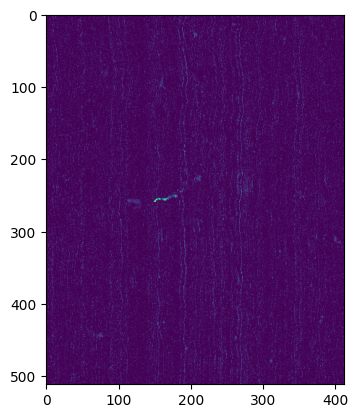

0.5044713697234421


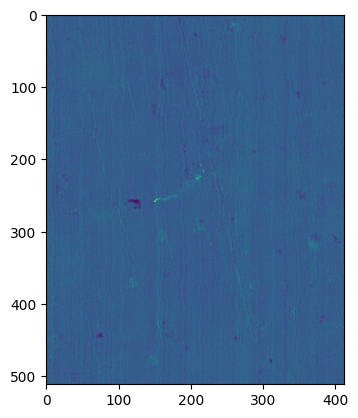

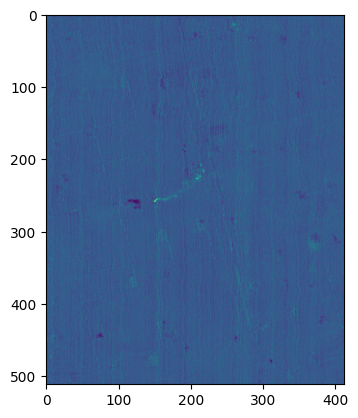

In [27]:
import numpy as np
import matplotlib.pyplot as plt
tile = np.load("test_tile.npy")[:,100:,:]
H,W,C = tile.shape
transmittance = np.load("test_transmittance.npy").astype(np.float32)
tile_flatten = tile.reshape((-1, C))
ace_result = ACE_sped_up_3(tile_flatten, transmittance)
ace_tile = ace_result.reshape((H,W))
plt.imshow(ace_tile)
plt.show()
print(ace_result.max())
mf_result = MatchedFilter_optimized(tile_flatten, transmittance)
mf_tile = mf_result.reshape((H,W))
plt.imshow(mf_tile)
plt.show()
cem_result = CEM_optimized(tile_flatten, transmittance)
cem_tile = cem_result.reshape((H,W))
plt.imshow(cem_tile)
plt.show()


In [ ]:
import torch
import torch.nn as nn

class ACEModel(nn.Module):
    def __init__(self):
        super(ACEModel, self).__init__()

    def forward(self, M, t):
        """
        Optimized Adaptive Coherent Estimator (ACE) using Cholesky decomposition in PyTorch.
        """
        u = M.mean(dim=0)
        M_centered = M - u  # [N, p]
        t_centered = t - u  # [p]
        N, p = M_centered.shape
        
        # Manual covariance matrix
        R_hat = (M_centered.T @ M_centered) / (N - 1)
        
        # Cholesky decomposition and solves
        L = torch.linalg.cholesky(R_hat)
        Gt = torch.cholesky_solve(t_centered.unsqueeze(1), L).squeeze(1)
        GM = torch.cholesky_solve(M_centered.T, L)  # [p, N]
        
        # Compute scores
        tmp = torch.dot(t_centered, Gt)
        num = torch.matmul(t_centered, GM).pow(2)
        denom = tmp * (M_centered * GM.T).sum(dim=1)
        
        return num / denom
    

class CEMModel(nn.Module):
    def __init__(self):
        super(CEMModel, self).__init__()

    def forward(self, M, t):
        """
        Constrained Energy Minimization (CEM) implementation using PyTorch
        """
        N, p = M.shape
        
        # Compute correlation matrix (no mean subtraction in CEM)
        R_hat = torch.matmul(M.T, M) / N  # [p, p]
        
        # Cholesky decomposition and solve
        L = torch.linalg.cholesky(R_hat)  # Lower triangular by default
        Rinv_t = torch.cholesky_solve(t.unsqueeze(1), L).squeeze(1)  # [p]
        denom = torch.dot(t, Rinv_t)  # Scalar
        
        # Compute scores
        scores = torch.matmul(M, Rinv_t) / denom  # [N]
        
        return scores
    

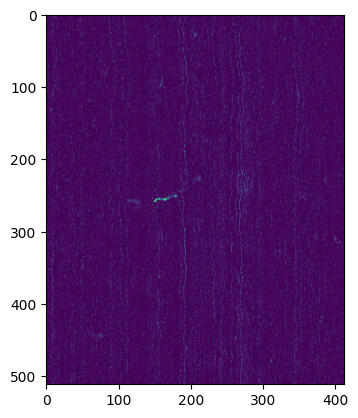

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 33 is not positive-definite).

In [29]:
#inference
# Create an instance of the ACE model
ace_model = ACEModel()
model_result = ace_model(torch.from_numpy(tile_flatten), torch.from_numpy(transmittance))
plt.imshow(model_result.reshape((H,W)))
plt.show()
cem_model = CEMModel()
model_result = cem_model(torch.from_numpy(tile_flatten), torch.from_numpy(transmittance))
plt.imshow(model_result.reshape((H,W)))
plt.show()

In [154]:

# Sample input tensors (random for testing)
N, p = 512, 200  # Example dimensions
M_sample = torch.randn(N, p, dtype=torch.float32)
t_sample = torch.randn(p, dtype=torch.float32)

# Convert to ONNX
torch.onnx.export(
    ace_model,
    (M_sample, t_sample),  # Input tuple
    "ace_model.onnx",
    input_names=["M", "t"],
    output_names=["ace_output"],
    dynamic_axes={
        "M": {0: "N"},  # Allow N to be dynamic
        "ace_output": {0: "N"}  # Output should also be dynamic
    },
    opset_version=11  # ONNX opset version
)

UnsupportedOperatorError: Exporting the operator 'aten::linalg_cholesky' to ONNX opset version 11 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

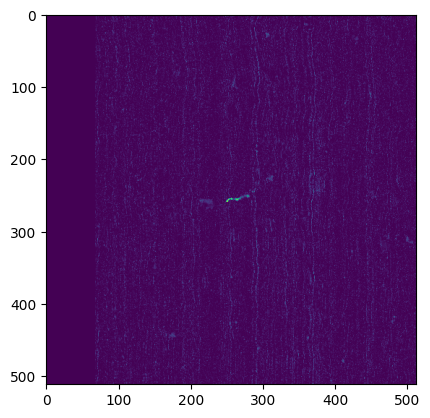

In [ ]:
ace_original = "blah/ang20191025t171141_r10528_c126_w151_h151/ace.npy"
print
plt.imshow(np.load(ace_original))